In [1]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)

from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [2]:
%load_ext autoreload
%autoreload 2

In [31]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats

np.random.seed(27);
torch.manual_seed(27);

In [4]:
#DEVICE = swyft.set_device(gpu=True)
DEVICE = 'cuda'

In [12]:
def model(v):
    a = v[0]
    b = v[1]
    x=np.array([a,2*(b-a)])
    return dict(mu=x)

def noise(obs, v, noise = 0.01):
    x = obs['mu']
    n = np.random.randn(*x.shape)*noise
    return dict(x=x + n)

In [26]:
v0 = np.array([0.55, 0.45])
obs0 = model(v0)

In [27]:
simulator = swyft.Simulator(model, obs_shapes = {"mu": (2,)})
store = swyft.MemoryStore(['z0', 'z1'], simulator = simulator)

In [28]:
prior = swyft.Prior.from_uv(lambda u: u, 2)
dataset = swyft.Dataset(500, prior, store = store, simhook = noise)
dataset.simulate()

In [29]:
post = swyft.Posteriors(dataset)
post.infer([(0, 1)], device = DEVICE)

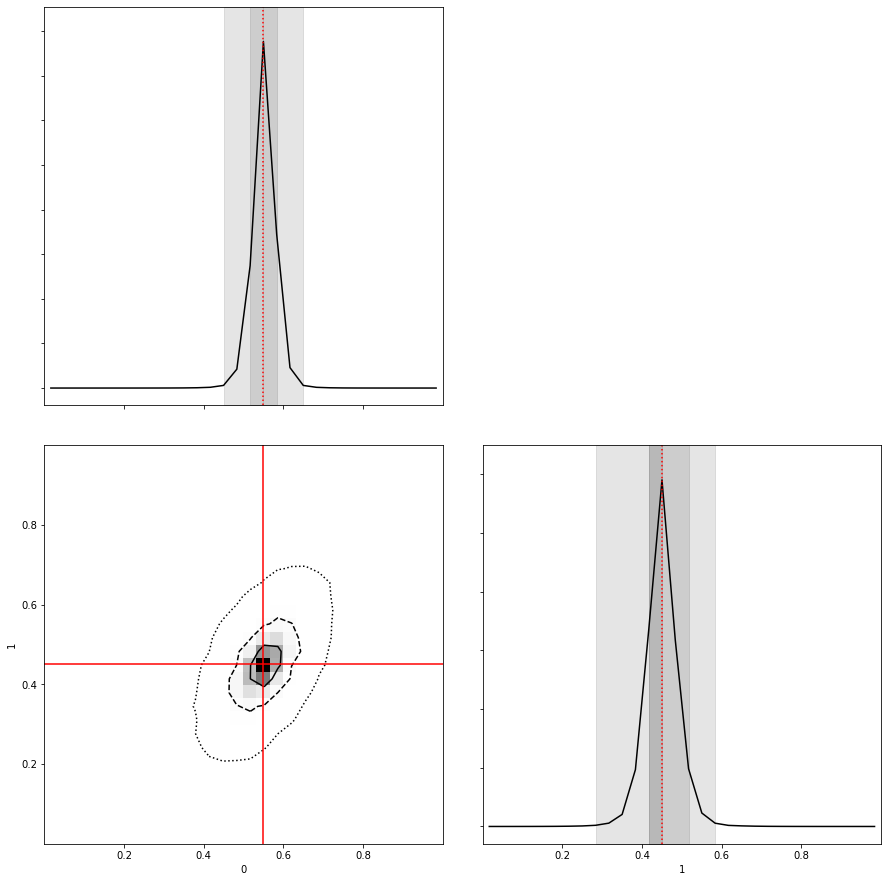

In [30]:
samples = post.sample(100000, obs0)
swyft.corner(samples, [0, 1], color='k', figsize = (15,15), truth=v0, bins = 30)